# HW10 - 貓狗照片分類
#### 【Python人工智慧實戰_2020-06-17】

In [1]:
# Import required libraries
from random import shuffle 
import cv2, os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Keras specific
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000 # cats+dogs
nb_validation_samples = 800 # cats+dogs
num_classes = 2 # predict outputs classes

In [3]:
def createdata(data_dir):
    X_data, y_data = list(), list()   
    for subdir in os.listdir(data_dir):
        sub_dir = os.path.join(data_dir, subdir).replace("\\","/")
        img_path = os.listdir(sub_dir)
        
        for i, img in enumerate(img_path):
            img_label = img.split('.')[0]            
            path = os.path.join(sub_dir, img).replace("\\","/")
            img = load_img(path, target_size=(img_width, img_height))
            img = img_to_array(img)
            # img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)           
            # img = cv2.resize(img, (img_width, img_height)) # 統一 150*150 大小
            X_data.append(img)
            y_data.append(np.array(img_label))
            
    return np.array(X_data), pd.Categorical(np.array(y_data)).codes # Encoding categorical features

In [4]:
X_train, y_train = createdata(train_data_dir)
X_test, y_test = createdata(validation_data_dir)
print(X_train.shape) # 資料筆數 * (150*150) 的黑白照片大小
print(y_train.shape) # 資料筆數 * 預測類別(一維)
print(X_test.shape)
print(y_test.shape)

(2000, 150, 150, 3)
(2000,)
(800, 150, 150, 3)
(800,)


In [5]:
# CNN 的 input image shape 須為 4D tensor (筆數 * R * G * B)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print(X_train.shape)
print(X_test.shape)

(2000, 150, 150, 3)
(800, 150, 150, 3)


In [6]:
# images normalization
X_train = X_train / 255 # RGB 數值皆介於 0~255
X_test = X_test / 255

In [7]:
# one hot encode outputs
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print(y_train.shape)
print(y_test.shape)

(2000, 2)
(800, 2)


In [8]:
'''
  channels_first: 色彩通道(R/G/B)資料(深度)放在第 2 維度，第 3、4 維度放置寬與高
  channels_last: 色彩通道(R/G/B)資料(深度)放在第 4 維度，第 2、3 維度放置寬與高
'''

def build_CNN(output_units, num_neurons=[32, 64, 128], drp_ratio=0.25):
    model = Sequential()
    
    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            # num of features in input layer
            model.add(Conv2D(n_units, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(drp_ratio)) # add dropout
        else:
            # add hidden layer
            model.add(Conv2D(n_units, kernel_size=(3, 3), activation='relu', padding='same'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(drp_ratio)) # add dropout
    
    model.add(Flatten())
    model.add(Dense(units=512, name="hidden_layer_1"))
    model.add(Dropout(0.5)) # add dropout
    model.add(Dense(units=output_units, activation="softmax", name="output"))
    return model

In [9]:
learning_rate = 0.001
batch_size = 64
epochs = 50 # [50, 100, 150] one epoch = Iterations（疊代）= N = numbers of training data/batch_size

In [10]:
# build CNN model
model = build_CNN(num_classes)

# summary model
model.summary()

# compile the model
optimizer = keras.optimizers.RMSprop(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)      

In [11]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height), # 轉成指定大小
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [12]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
31/31 [==============================] - 18s 581ms/step - loss: 4.1248 - accuracy: 0.5093 - val_loss: 0.6944 - val_accuracy: 0.5065
Epoch 2/50
31/31 [==============================] - 17s 558ms/step - loss: 0.7744 - accuracy: 0.5351 - val_loss: 0.6874 - val_accuracy: 0.5000
Epoch 3/50
31/31 [==============================] - 17s 535ms/step - loss: 0.7077 - accuracy: 0.5315 - val_loss: 0.6861 - val_accuracy: 0.4959
Epoch 4/50
31/31 [==============================] - 16s 522ms/step - loss: 0.6875 - accuracy: 0.5713 - val_loss: 0.6866 - val_accuracy: 0.5136
Epoch 5/50
31/31 [==============================] - 16s 510ms/step - loss: 0.6995 - accuracy: 0.5677 - val_loss: 0.6721 - val_accuracy: 0.6549
Epoch 6/50
31/31 [==============================] - 16s 519ms/step - loss: 0.6656 - accuracy: 0.6129 - val_loss: 0.6129 - val_accuracy: 0.6291
Epoch 7/50
31/31 [==============================] - 16s 501ms/step - loss: 0.6710 - accuracy: 0.6361 - val_loss: 0.5880 - val_accuracy: 0.6726

<Figure size 432x288 with 0 Axes>

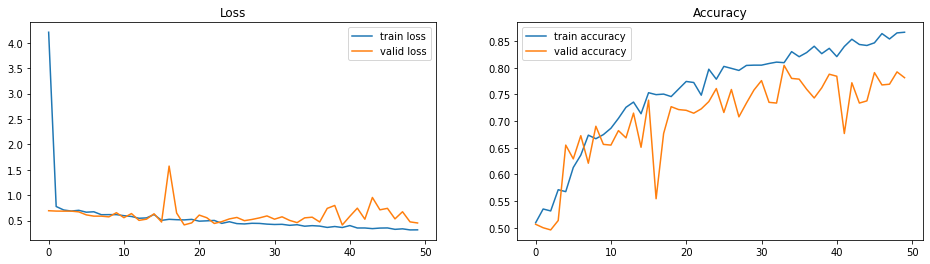

In [13]:
# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

plt.subplots_adjust(left=0.5)
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show

plt.subplot(1, 2, 2)
plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [14]:
def output_results(val):
    result=''
    if(val==0):
        result="cats"
    else:
        result="dogs"        
    return result

prediction class: dogs, label class: dogs
Accuracy on test data: 0.7762500047683716%


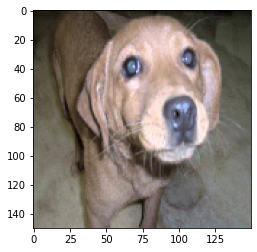

In [15]:
probs = model.predict(X_test)

print('prediction class: {}, label class: {}'.format(output_results(np.argmax(probs[0])), output_results(np.argmax(y_test[0]))))
scores = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}%'.format(scores[1]))
plt.imshow(X_test[0])
plt.show()

In [16]:
model.save_weights('CNN_model.h5')